In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.layers import GlobalAveragePooling1D, BatchNormalization, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras_tuner import HyperModel, BayesianOptimization

train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')

2024-11-27 04:53:15.690058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732683195.799174   36946 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732683195.829088   36946 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 04:53:16.095274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_adjacencies = [np.load(f'ADJ/train_adjacency_matrix_{i}.npy') for i in range(train_features.shape[0])]
test_adjacencies = [np.load(f'ADJ/test_adjacency_matrix_{i}.npy') for i in range(test_features.shape[0])]

In [3]:
train_adjacency_matrix = np.load(f'ADJ/train_adjacency_matrix_{0}.npy')

print(f'Adjacency Matrix for index {0}:\n')
print(train_adjacency_matrix)
print(train_adjacency_matrix.shape)

Adjacency Matrix for index 0:

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
(49, 49)


In [5]:
def normalize_adjacency(adjacency):
    """ 
    Normalize the adjacency matrix using symmetric normalization: D^(-1/2) * A * D^(-1/2).
    """
    d = tf.reduce_sum(adjacency, axis=-1) 
    d_inv_sqrt = tf.linalg.diag(1.0 / tf.sqrt(d + tf.keras.backend.epsilon())) 
    normalized_adjacency = tf.matmul(tf.matmul(d_inv_sqrt, adjacency), d_inv_sqrt)  

    return normalized_adjacency


In [7]:
class GraphConvLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None):
        super(GraphConvLayer, self).__init__()
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.weight = self.add_weight(
            shape=(input_shape[0][-1], self.output_dim),  
            initializer='random_normal',
            trainable=True
        )

    def call(self, inputs):
        features, adjacency = inputs
        output = tf.matmul(adjacency, features)  
        output = tf.matmul(output, self.weight) 

        if self.activation is not None:
            output = self.activation(output)
        return output

In [8]:
from keras_tuner import HyperModel, BayesianOptimization
from keras.layers import Input, BatchNormalization, LeakyReLU, Dropout, Dense, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

class GCNHyperModel(HyperModel):
    def build(self, hp):
        input_features = Input(shape=(7, 7, 2048)) 
        input_adjacency = Input(shape=(49, 49))

        reshaped_features = tf.keras.layers.Reshape((49, 2048))(input_features)
        normalized_adjacency = tf.keras.layers.Lambda(lambda x: normalize_adjacency(x))(input_adjacency)

        x = GraphConvLayer(hp.Int('units_1', 32, 128, step=32))([reshaped_features, normalized_adjacency])
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(hp.Float('dropout_1', 0.3, 0.6, step=0.1))(x)

        x = GraphConvLayer(hp.Int('units_2', 32, 128, step=32))([x, normalized_adjacency])
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(hp.Float('dropout_2', 0.3, 0.6, step=0.1))(x)

        x = GlobalAveragePooling1D()(x)
        x = Dense(128, activation='relu', kernel_regularizer=l2(hp.Float('l2_reg', 0.0, 0.1, step=0.01)))(x)
        x = Dropout(hp.Float('dropout_3', 0.3, 0.6, step=0.1))(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=[input_features, input_adjacency], outputs=output)
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='LOG')),
                      loss='binary_crossentropy', 
                      metrics=['binary_accuracy'])
        return model


tuner = BayesianOptimization(
    GCNHyperModel(),
    objective='val_binary_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='gcn_tuner',
    project_name='gcn_bayesian_optimization',
    overwrite=True
)

X_train_features, X_val_features, X_train_adjacencies, X_val_adjacencies, y_train, y_val = train_test_split(
    train_features, 
    train_adjacencies, 
    train_labels, 
    test_size=0.2, 
    random_state=42
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25, 
    verbose=1,
    mode='min',
    restore_best_weights=True
)

tuner.search(
    [X_train_features, X_train_adjacencies],
    y_train,
    epochs=100,
    batch_size=8, 
    validation_data=([X_val_features, X_val_adjacencies], y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")


Trial 5 Complete [00h 02m 04s]
val_binary_accuracy: 0.9964285492897034

Best val_binary_accuracy So Far: 0.9964285492897034
Total elapsed time: 00h 07m 21s
Best Hyperparameters: {'units_1': 96, 'dropout_1': 0.4, 'units_2': 128, 'dropout_2': 0.3, 'l2_reg': 0.02, 'dropout_3': 0.4, 'learning_rate': 0.00022751429316151273}


In [80]:
def create_gcn_model(best_hyperparameters):
    input_features = Input(shape=(7, 7, 2048))
    input_adjacency = Input(shape=(49, 49))

    reshaped_features = tf.keras.layers.Reshape((49, 2048))(input_features)
    normalized_adjacency = tf.keras.layers.Lambda(lambda x: normalize_adjacency(x))(input_adjacency)

    x = GraphConvLayer(best_hyperparameters.get('units_1'))([reshaped_features, normalized_adjacency])
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(best_hyperparameters.get('dropout_1'))(x)
    x = GraphConvLayer(best_hyperparameters.get('units_2'))([x, normalized_adjacency])
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(best_hyperparameters.get('dropout_2'))(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(best_hyperparameters.get('l2_reg')))(x)
    x = Dropout(best_hyperparameters.get('dropout_3'))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_features, input_adjacency], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['binary_accuracy'])
    
    return model


gcn_model = create_gcn_model(best_hyperparameters)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, 
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = gcn_model.fit(
    [X_train_features, X_train_adjacencies],
    y_train,
    epochs=300,
    batch_size=4,
    validation_data=([X_val_features, X_val_adjacencies], y_val),
    #callbacks=[early_stopping],
    verbose=1
)

/home/kavin/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/300


/home/kavin/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_36', 'keras_tensor_37']. Received: the structure of inputs=('*', '*')
  warnings.warn(


280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8079 - loss: 0.8235 - val_binary_accuracy: 0.9679 - val_loss: 0.2521
Epoch 2/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9152 - loss: 0.2855 - val_binary_accuracy: 0.9821 - val_loss: 0.1660
Epoch 3/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9384 - loss: 0.3026 - val_binary_accuracy: 0.9750 - val_loss: 0.1902
Epoch 4/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9129 - loss: 0.2647 - val_binary_accuracy: 0.9821 - val_loss: 0.1983
Epoch 5/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9396 - loss: 0.2323 - val_binary_accuracy: 0.9571 - val_loss: 0.1991
Epoch 6/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.9409 - loss: 0.2408 - val_binary_accuracy: 0.9786 - val_loss: 0.1492
Epoch 7/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9515 - loss: 0.2466 - val_binary_accuracy: 0.9786 - val_loss: 0.1657
Epoch 8/300

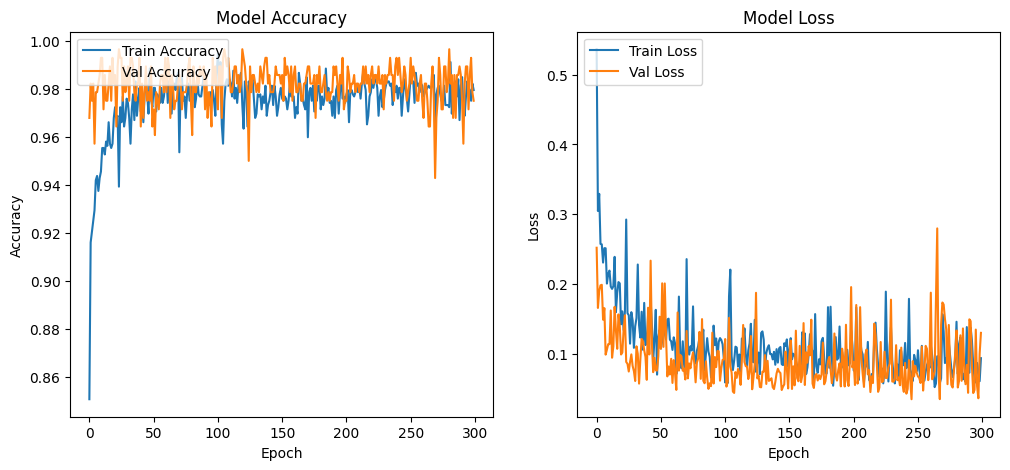

In [81]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


In [110]:
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')
test_adjacencies = [np.load(f'ADJ/test_adjacency_matrix_{i}.npy') for i in range(test_features.shape[0])]
test_adjacencies = np.array(test_adjacencies)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9681 - loss: 0.1527
test Test Loss: 0.21403303742408752
test Test Accuracy: 0.9611801505088806
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


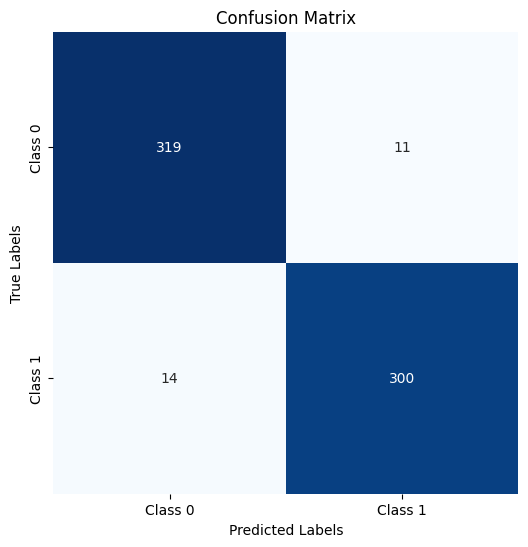

In [111]:

test_loss, test_acc = gcn_model.evaluate(
    [test_features, test_adjacencies], 
    test_labels,
    verbose=1
)

print(f"test Test Loss: {test_loss}")
print(f"test Test Accuracy: {test_acc}")

predictions = gcn_model.predict([test_features, test_adjacencies])

predicted_labels = (predictions > 0.5).astype(int)

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [112]:
from sklearn.metrics import classification_report
report = classification_report(test_labels, predicted_labels, digits=4)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9580    0.9667    0.9623       330
         1.0     0.9646    0.9554    0.9600       314

    accuracy                         0.9612       644
   macro avg     0.9613    0.9610    0.9611       644
weighted avg     0.9612    0.9612    0.9612       644



In [16]:
# from tensorflow.keras.models import load_model
# gcn_model.save('gcn_model.h5')
